In [2]:
from Wiki_Hurricane_Scraper import *
# from YouTube_Analytics import *
from FEMA_Scraper import *
from NOAA_Scraper import *
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
def getDisasterInfo():
    hurricaneDf = getHurricaneData()
    hurricaneDf = hurricaneDf[hurricaneDf['Season'] >= 2005].set_index("Name")
    name = hurricaneDf.index.tolist()
    season = hurricaneDf['Season'].tolist()
    locations = getAllLocations()
    disastersInfo = list(zip(name, season))
    return hurricaneDf, disastersInfo, name, locations

def getFundingDf(funding, disastersInfo, name, locations):
    fundingdf = pd.DataFrame(columns=['Year'] + locations, index=name)
    for hurricane, locs in funding.items():
        for loc, funds in locs.items():
            fundingdf.at[hurricane, loc] = funds+5
    for name, year in disastersInfo:
        fundingdf.at[name, 'Year'] = year 
    fundingdf.rename(index=str, columns={"- Any -":"Total"}, inplace=True)
    return fundingdf

def getYoutubeDFs(disastersinfo):
    return getAllDisasterDfs(disastersInfo)

def getNOAAFunding(kwargs):
    return getFundingDataFromNOAA(**kwargs)

def processTweetDf(file):
    df = pd.read_csv(file)
    df['Total Exposure'] = df[['replies', 'retweets', 'likes']].sum(axis=1)
    df.drop(['link', 'id', 'location'], axis=1, inplace=True)
    return df

def processYoutubeDf(file):
    df = pd.read_csv(file, index_col=0).reset_index().drop('index', axis=1)
    df.drop(['Favourite Count', 'Video ID'], axis=1, inplace=True)
    return df

def getCompiledDf(fundingDf, hurricaneDf, tweets_by_hurricane, youtube_by_hurricane):
    columns = ['Tweet Count', 'Tweet Exposure', 'Hashtags', 'Video Count', 'Video Exposure',
                   'Youtube Tags', 'Youtube Views', 'Youtube Comment Count', 'Youtube Likes', 'Youtube Dislikes', 'replies', 'retweets', 'likes']
    num_rows = len(tweets_by_hurricane)
    compiledDf = pd.DataFrame(columns=columns, index=hurricaneNames)
    compiledDf = compiledDf.merge(fundingDf[['Total']], how='outer', left_index=True, right_index=True)
    compiledDf.rename(index=str, columns={"Total":"Funding"}, inplace=True)
    compiledDf = compiledDf.merge(hurricaneDf[['Damages']], how='outer', left_index=True, right_index=True)
    for hurricane in hurricaneNames:
        if hurricane in tweets_by_hurricane:
            tweets = tweets_by_hurricane[hurricane]
            compiledDf.loc[hurricane, 'Tweet Count'] = len(tweets)
            compiledDf.loc[hurricane, 'Tweet Exposure'] = sum(tweets['Total Exposure'])
            compiledDf.loc[hurricane, 'Tweet Replies'] = sum(tweets['replies'])
            compiledDf.loc[hurricane, 'Tweet Retweets'] = sum(tweets['retweets'])
            compiledDf.loc[hurricane, 'Tweet Likes'] = sum(tweets['likes'])
            
            allhashes = [val.replace('\'', '') for res in tweets['hashtags'] if res != '[]' \
                                                 for val in res.replace('[', '').replace(']', '').split(', ')]
            compiledDf.loc[hurricane, 'Hashtags'] = ','.join(allhashes)
        vids = youtube_by_hurricane[hurricane]
        compiledDf.loc[hurricane, 'Video Count'] = len(vids)
        compiledDf.loc[hurricane, 'Video Exposure'] = sum(vids['Views'])
        compiledDf.loc[hurricane, 'Video Comment Count'] = sum(vids['Comment Count'])
        compiledDf.loc[hurricane, 'Video Likes'] = sum(vids['Likes'])
        compiledDf.loc[hurricane, 'Video Dislikes'] = sum(vids['Dislikes'])
#         compiledDf.loc[hurricane, 'Video Views'] = sum(vids['Views'])
        
        allTags = [val.replace('\'', '') for res in vids['Tags'] if res != '[]' \
                                                 for val in res.replace('[', '').replace(']', '').split(', ')]
        compiledDf.loc[hurricane, 'Youtube Tags'] = ','.join(allTags)
    return compiledDf

searchParamsFema = {'source' : 'https://www.fema.gov/disasters',
                'location' : 'Florida',
                'incidentType' : 'Hurricane',
                'declarationType' : 'DR',
                'startMonth' : 'January',
                'startYear' : 2013,
                'endMonth' : 'December',
                'endYear' : 2018,
                'disasterName' : 'Irma'}

searchQueryNOAA = {
    'eventType': '(Z) Storm Surge/Tide',
    'beginDate_mm': '01',
    'beginDate_dd': '01',
    'beginDate_yyyy': '2013',
    'endDate_mm': '12',
    'endDate_dd': '30',
    'endDate_yyyy': '2018',
    'county': 'ALL',
}

hurricaneDf, disastersInfo, hurricaneNames, locations = getDisasterInfo()

# funding = getAllFunding(disastersInfo, searchParamsFema)
# np.save("fundingDict.npy", funding)

### Collect The Fema Funds as a CSV File
# funding = np.load('fundingDict.npy').item()
# df = getFundingDf(funding, disastersInfo, hurricaneNames, locations)
# df.to_csv('fundingRaised.csv')

### Collect Youtube Stats as CSV file
# YouTubeDictDfs = getYouTubeDfs(disastersInfo)
# for idx, (key, value) in enumerate(YouTubeDictDfs.items()):
#     value.to_csv('YouTube Dataframes/'+key+'.csv')

In [4]:
### LOAD FUNDING DATAFRAME
fundingDf = pd.read_csv('fundingRaised.csv', index_col=0)
fundingDf.drop([col for col, val in fundingDf.sum().iteritems() if val == 0], axis=1, inplace=True)

### LOAD ALL TWEET DATAFRAMES
tweets_by_hurricane = {}
for file in os.listdir("tweet_csv"):
    hurricane = file.split('.')[0]
    tweets_by_hurricane[hurricane] = processTweetDf('tweet_csv/' + file)
    
### LOAD ALL YOUTUBE DATAFRAMES
youtube_by_hurricane = {}
for file in os.listdir("Youtube_Dataframes"):
    hurricane = file.split('.')[0]
    youtube_by_hurricane[hurricane] = processYoutubeDf('Youtube_Dataframes/' + file)
    
### Group Relevant Columns Together Across Df's
compiledDf = getCompiledDf(fundingDf, hurricaneDf, tweets_by_hurricane, youtube_by_hurricane)

In [27]:
youtube_by_hurricane

{'Alex':                                                  Title     Views  \
 0     Charice - Pyramid [featuring Iyaz] (Viral Video)  48667425   
 1                          Miranda Cosgrove - Kissin U  10604547   
 2                      Emily Osment - Let's Be Friends   9377637   
 3    Unusual shot by Alex Hurricane Higgins to beat...   1559275   
 4      Alex 'Hurricane' Higgins: latest interview 2010    375408   
 5    Puya - Americandrim (feat. Connect-R) | Videoc...    295558   
 6    Amazing Shots by Alex Hurricane Higgins - Best...    275590   
 7         Alex Megane - Hurricane (Cascada Radio Edit)    260670   
 8          Texas Task Force 1 South Texas Horse Rescue    148510   
 9    Video of severe flood in Monterrey as Hurrican...    134851   
 10    Oliver Reed talking about Alex Hurricane Higgins    104230   
 11   Huracan Alex en Monterrey México. (Rio Santa C...     89839   
 12   Huracan Alex en Monterrey (Rio Santa Catarina ...     80613   
 13   HURRICANE ALEX IN MO

In [33]:
compiledDf

,Tweet Count,Tweet Exposure,Hashtags,Video Count,Video Exposure,Youtube Tags,Youtube Views,Youtube Comment Count,Youtube Likes,Youtube Dislikes,...,retweets,likes,Funding,Damages,Video Comment Count,Video Likes,Video Dislikes,Tweet Replies,Tweet Retweets,Tweet Likes
Name,,,,,,,,,,,,,,,,,,,,,
Katrina,NaN,NaN,NaN,471,55869850,"U2,Green,Day,greenday,saints,are,coming,hurric...",NaN,NaN,NaN,NaN,...,NaN,NaN,2.367417e+10,1.250000e+11,53324.0,163243.0,14090.0,NaN,NaN,NaN
Harvey,32560,417220,"#HurricaneHarvey,#BigTree,#GulfCoast,#ShannaSw...",591,121010746,"Jake,Paul,logan,paul,its,every,day,Team,10,bro...",NaN,NaN,NaN,NaN,...,NaN,NaN,2.251865e+09,1.250000e+11,472003.0,3399304.0,159927.0,13810.0,115856.0,287554.0
Maria,18069,281223,"#PuertoRico,#DanaDurnford,#Fukushima,#Maria,#H...",596,17201149,"SNL,Saturday Night Live,hurricane,puerto rico,...",NaN,NaN,NaN,NaN,...,NaN,NaN,3.890758e+09,9.160000e+10,45678.0,187884.0,11984.0,10957.0,110171.0,160095.0
Sandy,117888,121569,"#architecture,#NYC,#Sandy,#NY,#hurricane,#sand...",574,169543069,"Robbie,Williams,Candy,Universal,Music,Pop,Will...",NaN,NaN,NaN,NaN,...,NaN,NaN,1.757500e+10,6.870000e+10,138566.0,933021.0,38168.0,14983.0,82965.0,23621.0
Irma,11969,78345,"#SXMsmilesAgain,#VisitFrance,#mediaEvent,#Irma...",580,188991027,"Hurricane Irma,St Maarten,Maho Beach,category ...",NaN,NaN,NaN,NaN,...,NaN,NaN,1.194377e+09,6.480000e+10,407653.0,2306935.0,120279.0,3616.0,22890.0,51839.0
Ike,424,3,"#cheesy,#2,#baggyrinkle,#1,#gno,#CurrentEvents",503,313498399,"Black,Eyed,Peas,Interscope,Pop,Hurricane,Ike,h...",NaN,NaN,NaN,NaN,...,NaN,NaN,3.048525e+09,3.800000e+10,65940.0,1014890.0,47063.0,0.0,0.0,3.0
Wilma,NaN,NaN,NaN,492,13836572,"Hurricane,Katrina,Storm,Chaser,Extreme,Video,H...",NaN,NaN,NaN,NaN,...,NaN,NaN,1.831665e+09,2.740000e+10,5895.0,12017.0,3020.0,NaN,NaN,NaN
Rita,NaN,NaN,NaN,470,29783360,"gospel,worship,Gregory,Isaacs,Night,Nurse,regg...",NaN,NaN,NaN,NaN,...,NaN,NaN,2.193736e+09,1.850000e+10,12136.0,43516.0,3959.0,NaN,NaN,NaN
Matthew,3780,12699,"#stormresponse,#stormresponse,#Haiti,#aid,#the...",591,908965154,"Imagine,Dragons,Thunder,KIDinaKORNER/Interscop...",NaN,NaN,NaN,NaN,...,NaN,NaN,1.040971e+09,1.510000e+10,768626.0,7104012.0,586665.0,429.0,4974.0,7296.0


In [7]:
fundingDf['Year'].values

array([2005, 2017, 2017, 2012, 2017, 2008, 2005, 2005, 2016, 2011, 2008,
       2005, 2010, 2005, 2012, 2011, 2007, 2008, 2010, 2013, 2005])

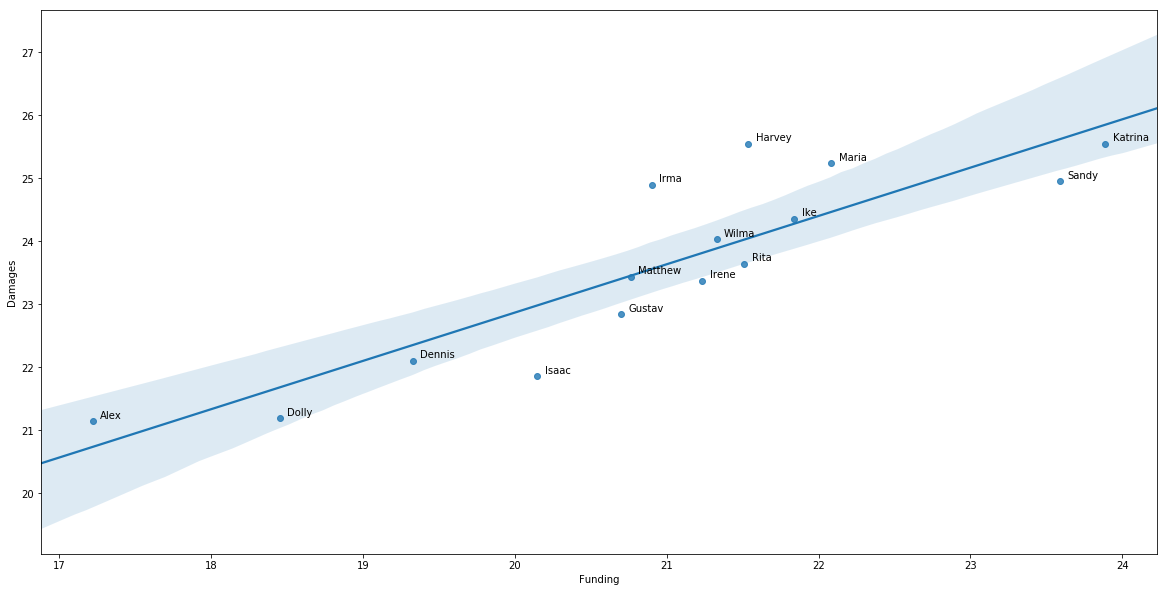

In [219]:
locs = df['Funding']>100
plotx = np.log(df['Funding'][locs])
ploty = np.log(df['Damages'][locs])
ax = sns.regplot(plotx, ploty) #, fit_reg=False)
a = pd.concat({'x': plotx, 'y': ploty}, axis=1)
for ((i, point), name) in zip(a.iterrows(), df.index[locs]):
    ax.text(point['x']+0.05, point['y']+0.05, name)
plt.show()

In [220]:
### Adjusting Funding and Damages for Inflation at an average of 1.89% per year [CITE THIS]
inflationAdjustedDf = df.copy()
def calcInflation()